# Logistic Regression — Example Notebook

This notebook demonstrates how to use `rice_ml.supervised_learning.LogisticRegression` for:
- Binary classification (sigmoid)
- Multiclass classification (softmax / multinomial)
- The effect of feature standardization
- The effect of L2 regularization
- Visualizing decision boundaries and training loss

## Datasets used in this notebook

This time we did not use any real dataset from sklearn. We used **synthetic Gaussian blob datasets** instead to see how it works:

### Dataset A: Binary 2D blobs
- **Samples**: 320 (160 per class)
- **Features**: 2 numerical features (`x1`, `x2`)
- **Labels**: `{0,1}`
- **Goal**: learn a linear separator and visualize a 2D decision boundary.

### Dataset B: Multiclass 2D blobs
- **Samples**: 360 (120 per class)
- **Features**: 2 numerical features (`x1`, `x2`)
- **Labels**: `{"A","B","C"}`
- **Goal**: demonstrate softmax logistic regression and visualize decision regions.



## 1. Set up

In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# --- Ensure we can import from src/ ---
here = Path.cwd()
repo_root = None
for p in [here] + list(here.parents):
    if (p / "src" / "rice_ml").exists():
        repo_root = p
        break

if repo_root is None:
    raise RuntimeError("Could not find 'src/rice_ml'. Run this notebook inside the repo.")

sys.path.insert(0, str(repo_root / "src"))

from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.supervised_learning.logistic_regression import LogisticRegression

np.random.seed(42)


## 2. Helpers

We define small utility functions for:
- confusion matrix (NumPy-only)
- decision boundary plotting for 2D data


In [2]:
def confusion_matrix_np(y_true, y_pred, labels=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    labels = np.asarray(labels)
    k = len(labels)
    idx = {lab: i for i, lab in enumerate(labels)}
    cm = np.zeros((k, k), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm, labels


def plot_decision_boundary_binary(ax, model, X, y, title="", grid_steps=250):
    # X: (n,2)
    x_min, x_max = X[:, 0].min() - 0.7, X[:, 0].max() + 0.7
    y_min, y_max = X[:, 1].min() - 0.7, X[:, 1].max() + 0.7

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_steps),
        np.linspace(y_min, y_max, grid_steps),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    proba = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    ax.contour(xx, yy, proba, levels=[0.5], linewidths=2)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25)
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")


def plot_decision_regions_multiclass(ax, model, X, y, title="", grid_steps=250):
    x_min, x_max = X[:, 0].min() - 0.7, X[:, 0].max() + 0.7
    y_min, y_max = X[:, 1].min() - 0.7, X[:, 1].max() + 0.7

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_steps),
        np.linspace(y_min, y_max, grid_steps),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    pred = model.predict(grid).reshape(xx.shape)

    # map labels to ints for plotting
    labs = np.unique(np.concatenate([y, pred.ravel()]))
    lab_to_int = {lab: i for i, lab in enumerate(labs)}
    Z = np.vectorize(lab_to_int.get)(pred)

    ax.contourf(xx, yy, Z, alpha=0.25)
    # scatter points
    y_int = np.vectorize(lab_to_int.get)(y)
    ax.scatter(X[:, 0], X[:, 1], c=y_int, s=25)

    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")


## 3. Part A: Dataset A — Binary 2D Gaussian blobs (synthetic)

**Data description**
- Total samples: 320 (160 per class)
- Features: 2 continuous features (`x1`, `x2`)
- Labels: integers `{0,1}`
- Generation: two Gaussian clusters with different means (roughly linearly separable)

We train logistic regression on the standardized features and visualize the learned decision boundary.



X shape: (320, 2)
y shape: (320,)
class counts: {0: 160, 1: 160}


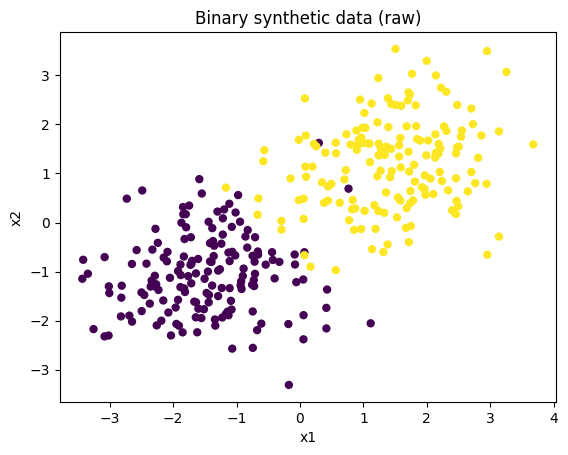

In [3]:
rng = np.random.default_rng(42)
n0, n1 = 160, 160

# Two clusters
X0 = rng.normal(loc=(-1.5, -1.0), scale=0.9, size=(n0, 2))
X1 = rng.normal(loc=( 1.5,  1.2), scale=0.9, size=(n1, 2))

X = np.vstack([X0, X1])
y = np.array([0]*n0 + [1]*n1)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("class counts:", {0: int((y==0).sum()), 1: int((y==1).sum())})

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=25)
plt.title("Binary synthetic data (raw)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


## Train/test split + Standardization

Important: we **fit** standardization parameters on the training set only,
then apply the same mean/scale to the test set to avoid data leakage.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42
)

X_train_std, params = standardize(X_train, return_params=True)
mean = params["mean"]
scale = params["scale"]
X_test_std = (X_test - mean) / scale

print("Train mean (approx):", X_train_std.mean(axis=0))
print("Train std  (approx):", X_train_std.std(axis=0))
print("Test  mean (approx):", X_test_std.mean(axis=0))
print("Test  std  (approx):", X_test_std.std(axis=0))


Train mean (approx): [ 1.75785312e-17 -4.62592927e-19]
Train std  (approx): [1. 1.]
Test  mean (approx): [0.07113968 0.04243971]
Test  std  (approx): [1.06802516 0.92820573]


## Fit binary Logistic Regression

We train with gradient descent and evaluate accuracy on train/test.
We also plot the training loss curve (loss vs iterations).


Binary LogisticRegression:
  n_iter_: 5000
  final loss: 0.08533640464005199
  train acc: 0.9708333333333333
  test  acc: 0.975


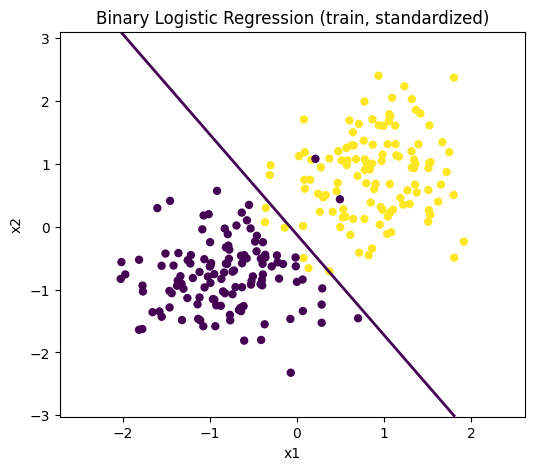

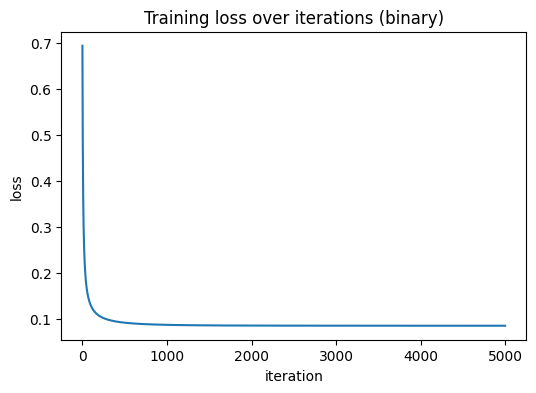

Confusion matrix (test): rows=true, cols=pred
[[37  0]
 [ 2 41]]


In [5]:
clf = LogisticRegression(
    learning_rate=0.2,
    max_iter=5000,
    tol=1e-8,
    l2=0.0,
    batch_size=None,          # full-batch GD
    multi_class="auto",
    random_state=42
).fit(X_train_std, y_train)

train_acc = clf.score(X_train_std, y_train)
test_acc = clf.score(X_test_std, y_test)

print("Binary LogisticRegression:")
print("  n_iter_:", clf.n_iter_)
print("  final loss:", clf.loss_history_[-1] if clf.loss_history_ else None)
print("  train acc:", train_acc)
print("  test  acc:", test_acc)

# Decision boundary (train)
fig = plt.figure(figsize=(6, 5))
ax = plt.gca()
plot_decision_boundary_binary(
    ax, clf, X_train_std, y_train,
    title="Binary Logistic Regression (train, standardized)"
)
plt.show()

# Loss curve
plt.figure(figsize=(6, 4))
plt.plot(clf.loss_history_)
plt.title("Training loss over iterations (binary)")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

# Confusion matrix on test
y_pred = clf.predict(X_test_std)
cm, labels = confusion_matrix_np(y_test, y_pred, labels=np.array([0, 1]))
print("Confusion matrix (test): rows=true, cols=pred")
print(cm)


## L2 regularization effect

We compare:
- No regularization (l2 = 0)
- Moderate regularization (l2 > 0)

We look at:
- coefficient norm
- accuracy
- decision boundary shape (in 2D it often becomes "less extreme")


No reg:
  test acc: 0.975
  ||w||2: 5.635329579467849
L2 reg (l2=2.0):
  test acc: 0.9625
  ||w||2: 0.23882596135882114


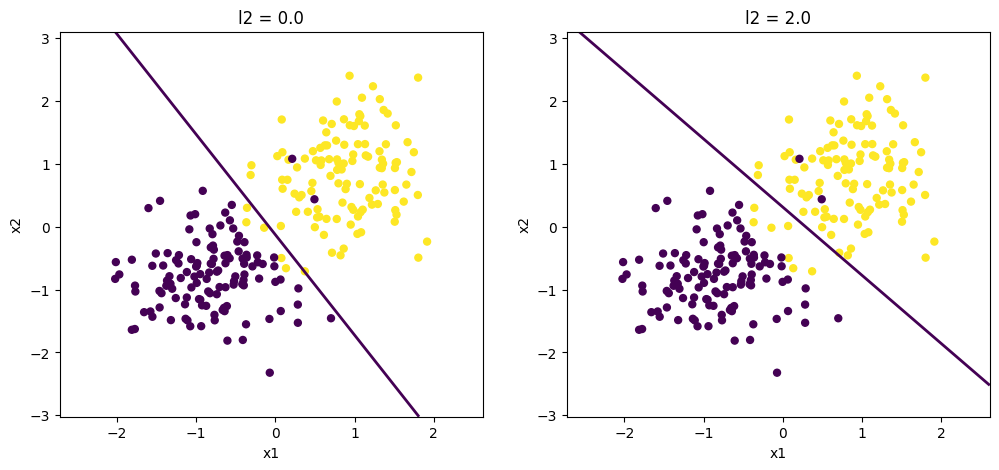

In [6]:
clf0 = LogisticRegression(
    learning_rate=0.2, max_iter=5000, tol=1e-8, l2=0.0, random_state=42
).fit(X_train_std, y_train)

clf1 = LogisticRegression(
    learning_rate=0.2, max_iter=5000, tol=1e-8, l2=2.0, random_state=42
).fit(X_train_std, y_train)

w0 = clf0.coef_
w1 = clf1.coef_

print("No reg:")
print("  test acc:", clf0.score(X_test_std, y_test))
print("  ||w||2:", float(np.linalg.norm(w0)))
print("L2 reg (l2=2.0):")
print("  test acc:", clf1.score(X_test_std, y_test))
print("  ||w||2:", float(np.linalg.norm(w1)))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary_binary(axes[0], clf0, X_train_std, y_train, title="l2 = 0.0")
plot_decision_boundary_binary(axes[1], clf1, X_train_std, y_train, title="l2 = 2.0")
plt.show()


## 4. Part B: Dataset B — Multiclass 2D Gaussian blobs (synthetic)

**Data description**
- Total samples: 360 (120 per class)
- Features: 2 continuous features (`x1`, `x2`)
- Labels: strings `{"A","B","C"}`
- Generation: three Gaussian clusters

We train **multinomial / softmax logistic regression** and visualize decision regions.



X3 shape: (360, 2)
classes: ['A', 'B', 'C']


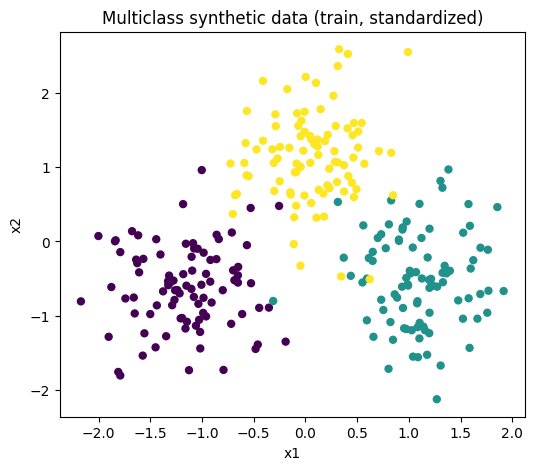

In [7]:
rng = np.random.default_rng(7)
n = 120

C0 = rng.normal(loc=(-2.0, 0.0), scale=0.8, size=(n, 2))
C1 = rng.normal(loc=( 2.0, 0.0), scale=0.8, size=(n, 2))
C2 = rng.normal(loc=( 0.0, 2.2), scale=0.8, size=(n, 2))

X3 = np.vstack([C0, C1, C2])
# Use string labels to show the model supports non-numeric classes
y3 = np.array(["A"]*n + ["B"]*n + ["C"]*n, dtype=object)

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.25, shuffle=True, random_state=42, stratify=y3
)

X3_train_std, params3 = standardize(X3_train, return_params=True)
m3, s3 = params3["mean"], params3["scale"]
X3_test_std = (X3_test - m3) / s3

print("X3 shape:", X3.shape)
print("classes:", np.unique(y3).tolist())

plt.figure(figsize=(6,5))
# map strings to ints just for color
labs = np.unique(y3)
lab_to_int = {lab:i for i, lab in enumerate(labs)}
plt.scatter(X3_train_std[:,0], X3_train_std[:,1], c=np.vectorize(lab_to_int.get)(y3_train), s=25)
plt.title("Multiclass synthetic data (train, standardized)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


## 5. Fit multinomial Logistic Regression (softmax)

We train with `multi_class="multinomial"` and evaluate accuracy + confusion matrix.


Multiclass LogisticRegression (multinomial):
  classes_: ['A', 'B', 'C']
  n_iter_: 70
  final loss: 0.9133109665726248
  train acc: 0.9555555555555556
  test  acc: 0.9888888888888889


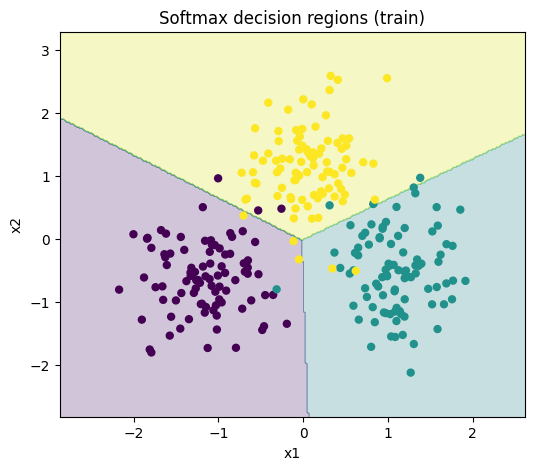

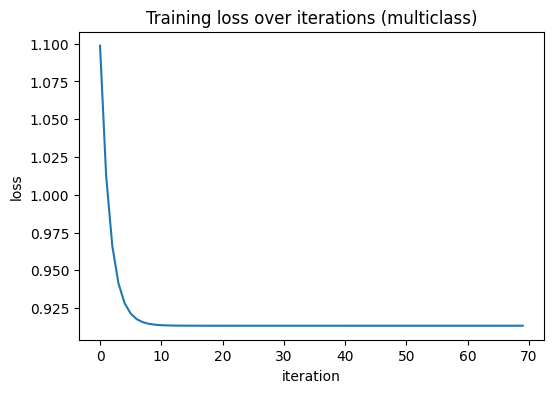

Confusion matrix (test): rows=true, cols=pred
labels: ['A', 'B', 'C']
[[30  0  0]
 [ 0 30  0]
 [ 1  0 29]]


In [ ]:
clf3 = LogisticRegression(
    multi_class="multinomial",
    learning_rate=0.2,
    max_iter=6000,
    tol=1e-8,
    l2=1.0,
    random_state=42
).fit(X3_train_std, y3_train)

train_acc3 = clf3.score(X3_train_std, y3_train)
test_acc3 = clf3.score(X3_test_std, y3_test)

print("Multiclass LogisticRegression (multinomial):")
print("  classes_:", clf3.classes_.tolist())
print("  n_iter_:", clf3.n_iter_)
print("  final loss:", clf3.loss_history_[-1] if clf3.loss_history_ else None)
print("  train acc:", train_acc3)
print("  test  acc:", test_acc3)

# Decision regions
plt.figure(figsize=(6,5))
ax = plt.gca()
plot_decision_regions_multiclass(ax, clf3, X3_train_std, y3_train, title="Softmax decision regions (train)")
plt.show()

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(clf3.loss_history_)
plt.title("Training loss over iterations (multiclass)")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

# Confusion matrix (test)
y3_pred = clf3.predict(X3_test_std)
cm3, labels3 = confusion_matrix_np(y3_test, y3_pred, labels=clf3.classes_)
print("Confusion matrix (test): rows=true, cols=pred")
print("labels:", labels3.tolist())
print(cm3)


## 6. Conclusion

We used **Logistic Regression** to solve both a **binary** and a **multiclass** classification problem on **synthetic 2D datasets**. Even though the data are simple, they make the model behavior very easy to visualize and interpret.

### Binary classification (sigmoid)
- The raw scatter plot shows **two clusters that are almost linearly separable**, so a linear decision boundary is a good fit.
- After standardizing features, training converged smoothly: the loss curve drops quickly at the beginning and then **plateaus at a low value** (final loss ≈ **0.085**).
- The model achieves **high accuracy** on both splits (**train ≈ 0.971**, **test ≈ 0.975**), which matches what we see in the decision-boundary plot: most points are clearly on the correct side of the line.

### Effect of L2 regularization
- With **no regularization**, the classifier keeps a relatively large weight norm (‖w‖₂ ≈ **5.64**) and reaches **test acc ≈ 0.975**.
- With **L2 = 2.0**, the weight norm shrinks dramatically (‖w‖₂ ≈ **0.24**), showing how regularization **penalizes large coefficients** and produces a “flatter” boundary in parameter space.
- In this dataset, regularization slightly reduces test accuracy (**0.9625**). That’s not necessarily “bad”—it just means the unregularized model was not overfitting much here, so the extra bias from strong regularization can hurt a little.

### Multiclass classification (softmax / multinomial)
- The 3-class dataset forms three well-separated groups, and the softmax decision-region plot shows **three linear regions** separated by straight boundaries (a key property of multinomial logistic regression).
- Training converges very quickly (**70 iterations**) with a stable final loss (≈ **0.913**).
- Performance is near-perfect (**train ≈ 0.956**, **test ≈ 0.989**). The confusion matrix confirms this: only **1** test point is misclassified (true **C** predicted as **A**).


Logistic Regression is a **strong baseline** when classes can be separated reasonably well by **linear boundaries**. The plots help confirm what the metrics say:
- binary: one straight line separates the two groups well;
- multiclass: softmax partitions the plane into several linear regions.
Regularization mainly controls coefficient magnitude and can improve robustness, but its benefit depends on how noisy/overfit-prone the dataset is.
